### VAESIM v6

1) Build on best performances from sweep
2) Introduce temperature scaling


In [1]:
%pip install imutils
%pip install opencv-python
%pip install torchextractor
%pip install omegaconf


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append("../../NeuroGEN_Pytorch/")
import torch
import torch.distributions as D
import matplotlib.pyplot as plt

import numpy as np
from torch import nn

from classes.Architectures import VAEDecoder, VAEEncoder, Discriminator,cVAEDecoder
from classes.Cluster import VAESIM
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST,CIFAR10
from torchvision.transforms import Compose,ToTensor,Resize,PILToTensor

from torchsummary import summary

from torch import distributions as D
from torch.nn.functional import softmax
import wandb

from imutils import paths
import matplotlib.pyplot as plt
import tqdm
from utils.callbacks import *

from sklearn.metrics import classification_report
from scipy.optimize import linear_sum_assignment
from utils.utils import linear_assignment
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.manifold import TSNE

import os
import seaborn as sns
#from coclust.evaluation.external import accuracy
import pandas as pd
wandb.login()
from evaluations import *

import medmnist
from medmnist import INFO, Evaluator

/home/matteo/Unsupervised/vaesim_baselines/VAESIM/../../NeuroGEN_Pytorch/utils/utils.py:134: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante (torvergatafmri). Use `wandb login --relogin` to force relogin


In [3]:
class encoder(nn.Module):
    
    def __init__(self,latent_dim=50,n_conv=3,n_init_filters=32,input_channels=1):
        super().__init__()
        layers=[]
        for i in range(n_conv):
            if i==0:
                layers.append(nn.Conv2d(input_channels,n_init_filters,kernel_size=4,stride=2,padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(n_init_filters))
            else:
                layers.append(nn.Conv2d(n_init_filters*(2**(i-1)),n_init_filters*2**i,kernel_size=4,stride=2,padding=1))
                layers.append(nn.ReLU())
                layers.append(nn.BatchNorm2d(n_init_filters*2**i))
        layers.append(nn.Flatten())
        layers.append(nn.LazyLinear(latent_dim))
        
        self.network=nn.Sequential(*layers)
        
    def forward(self,x):
        return self.network(x)
        
        
        

In [4]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=2,padding=1,separable=True):
        super().__init__()
        
        self.out_channels=out_channels
        
        if separable:
            self.conv=DepthSepConv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        else:
            self.conv=nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.norm=nn.BatchNorm2d(out_channels)
        self.act = nn.GELU()
        
    def forward(self,x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        
        return x
    
    
class ConvTransposeBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride=2,padding=1,separable=False):
        super().__init__()
        
        self.in_channels=in_channels
        self.out_channels=out_channels
        if separable:
            self.conv=DepthSepConvTranspose2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        else:
            self.conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.norm=nn.BatchNorm2d(out_channels)
        self.act = nn.GELU()
        
    def forward(self,x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        
        return x
            

class decoder(nn.Module):

    def __init__(self, latent_dim=50,target_shape=(1,28,28) , n_conv=2, n_init_filters=64, condition_dim=10):

        super().__init__()

        self.condition_dim=condition_dim



        # infer the starting dimension.
        target_shape_side = target_shape[-1]



        self.startDim = target_shape_side // (2 ** n_conv)

        self.n_init_filters=n_init_filters
        
        #self.predecoder=nn.Unflatten(self.first_channels*self.startDim*self.startDim)
        self.predecoder=nn.Linear(latent_dim,self.n_init_filters*self.startDim*self.startDim)
        self.unflatten=nn.Unflatten(1,(self.n_init_filters,self.startDim,self.startDim))

        self.condition =  nn.Linear(self.condition_dim,self.startDim*self.startDim)
        self.condition2shape = nn.Unflatten(1, (1,self.startDim , self.startDim))
        feature_layers = []
        for i in range(n_conv):
            if i==0:
                feature_layers.append(nn.LazyConvTranspose2d(n_init_filters,kernel_size=4,stride=2,padding=1))
            else:
                feature_layers.append(nn.ConvTranspose2d(n_init_filters*(2**(i-1)),n_init_filters*2**i,kernel_size=4,stride=2,padding=1))

        self.features = nn.Sequential(*feature_layers)

        self.decoder_output=nn.LazyConvTranspose2d(target_shape[0],3,padding=1)
        self.activation=nn.Sigmoid()

    def forward(self,x,c):
        x = self.predecoder(x)
        x= self.unflatten(x)

        c= self.condition(c)
        c= self.condition2shape(c)
        
        x= torch.concat((x,c),axis=1)
        x = x.view(x.shape[0], -1, self.startDim, self.startDim)
        x = self.features(x)
        x = self.decoder_output(x)
        x = self.activation(x)

        return x
    
    
## CONDITIONAL DECODER
class cDecoder(nn.Module):
    def __init__(self,latent_dim,conv_filters,target_dim=(1,32,32),init_channels=1,kernel_size=4,first_channels=32,condition_dim=10):
        
        super().__init__()
        
        self.startDim=int(target_dim[-1]/2**(len(conv_filters)))
        self.condition_dim=condition_dim
        
        l=len(conv_filters)
        conv=[]
        conv_filters=[first_channels+1]+conv_filters
        
        
        self.predecoder=nn.Linear(latent_dim,first_channels*self.startDim*self.startDim)
        self.unflatten=nn.Unflatten(1,(first_channels,self.startDim,self.startDim))
        
        self.condition =  nn.Linear(self.condition_dim,self.startDim*self.startDim)
        self.condition2shape = nn.Unflatten(1, (1,self.startDim , self.startDim))
        
        
        
        for i in range(l):
            conv.append(ConvTransposeBlock(conv_filters[i],conv_filters[i+1],kernel_size))
        
        self.decoder_output=nn.LazyConvTranspose2d(init_channels,kernel_size=3,padding=1)
        self.activation=nn.Sigmoid()
        
        self.features=nn.Sequential(*conv)
                        
    def forward(self,x,c):
        
        x = self.predecoder(x)
        x= self.unflatten(x)

        c= self.condition(c)
        c= self.condition2shape(c)

        x= torch.concat((x,c),axis=1)
        
        x= self.features(x)
        x = self.decoder_output(x)
        x = self.activation(x)
        
        return x
    


#### TRAINING

In [5]:
n_basis=40
latent_dim=32
input_dim=(1,32,32)

sample_cluster=False
kl_weight=5e-3
sim_weight=0.1
similarity=True
kl=True
reinit=0.

temperature=5

## using VAEEncoder
encoder_architecture=[(0,128),(0,256),(0,384)]
decoder_architecture=[(0,384),(0,256),(0,128)]


e=VAEEncoder( latent_dim=latent_dim,  conv_layer_list=encoder_architecture)
d=cDecoder(latent_dim,[384,256,128],condition_dim=n_basis)


model=VAESIM(input_dim=input_dim,latent_dim=latent_dim,encoder=e,decoder=d,n_basis=n_basis,weight=kl_weight,sim_weight=sim_weight,similarity=similarity,kl=kl,sample_cluster=sample_cluster,reinit=reinit,temperature=temperature,schedule=True,ema=0.95)


EPOCHS=60
BS=2000
INIT_LR=1e-4

config={"dataset":"MNIST10", "type":"VAESIM","latent_dim":latent_dim, "n_basis":n_basis, "input_dim":input_dim}
config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR

config["sample_cluster"]=sample_cluster
config["use_kl_loss"]=kl
config["use_similarity_loss"]=similarity
config["reinitialization_probability"]=reinit
config["kl_weight"]=kl_weight
config["sim_weight"]=sim_weight




wandb.init(project="NeuroGEN_Pytorch",config=config)



[INFO] Running model with KL: True, similarity loss: True and sampling: False temperature: 5 reinitilize: 0.0 ema: 0.95 


/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using {device} device")

Using cuda:0 device


## Run this cell to Init the basis

Computing t-SNE to visualize from 32 to 2 dim - this could take a while..


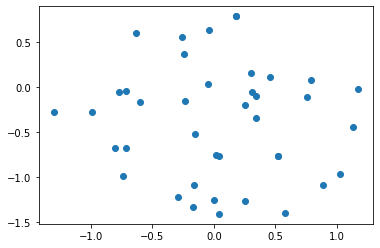

In [7]:
x=torch.rand(BS,*input_dim).to(device)
z_mean,z_log_var=model.encoder(x)
q_z = D.normal.Normal(z_mean, torch.exp(0.5 * z_log_var))
z=q_z.rsample()

model.init_basis(z.detach().cpu())

In [8]:
summary(model,input_dim)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           2,176
      ConvResBlock-2          [-1, 128, 16, 16]               0
            Conv2d-3            [-1, 256, 8, 8]         524,544
      ConvResBlock-4            [-1, 256, 8, 8]               0
            Conv2d-5            [-1, 384, 4, 4]       1,573,248
      ConvResBlock-6            [-1, 384, 4, 4]               0
           Flatten-7                 [-1, 6144]               0
            Linear-8                   [-1, 32]         196,640
            Linear-9                   [-1, 32]         196,640
       VAEEncoder-10       [[-1, 32], [-1, 32]]               0
           Linear-11                  [-1, 512]          16,896
        Unflatten-12             [-1, 32, 4, 4]               0
           Linear-13                   [-1, 16]             656
        Unflatten-14              [-1, 

In [9]:
transform=Compose([Resize(32),ToTensor()])

data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

#train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
#test_dataloader=DataLoader(test_dataset,batch_size=BS,shuffle=False)

train_dataset = DataClass(split='train', transform=transform, download=download)
val_dataset = DataClass(split='val', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)
testval_dataset=val_dataset+test_dataset


train_dataloader=DataLoader(train_dataset,batch_size=BS,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=BS,shuffle=True)

test_dataloader=DataLoader(testval_dataset,batch_size=BS,shuffle=True)

Using downloaded and verified file: /home/matteo/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/matteo/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/matteo/.medmnist/pneumoniamnist.npz


In [10]:
base_path="models/vaesim_pneumonia"
os.makedirs(base_path,exist_ok=True)

In [11]:
train=True
if train:
    optimizer=torch.optim.Adam(model.parameters(),lr=INIT_LR)
    #optimizer=torch.optim.SGD(model.parameters(),lr=INIT_LR,momentum=0.9)
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.2)

    loss_history,recon_loss_history,kl_loss_history,sim_loss_history=model.fit(train_dataloader=train_dataloader,val_dataloader=test_dataloader,epochs=EPOCHS,optimizer=optimizer,device=device,wandb_log=False,save_model=base_path,early_stop=10,scheduler=scheduler)

else:
    model.load_state_dict(torch.load("models/vaesim_mnist/model.pt"))
    model.basis=torch.load("models/vaesim_mnist/vaesim_basis.pt")
    model=model.to(device)
    model.device=device

Epoch 0: 100%|█| 3/3 [00:01<00:00,  2.83batch/s, loss=0.176, sim_loss=0.0296, recon_loss=0.146, kl_loss
/home/matteo/Unsupervised/vaesim_baselines/VAESIM/../../NeuroGEN_Pytorch/utils/callbacks.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c=torch.nn.functional.softmax(logprobs/0.25)
Epoch 1: 100%|█| 3/3 [00:01<00:00,  2.86batch/s, loss=0.557, sim_loss=0.446, recon_loss=0.105, kl_loss=
Epoch 2: 100%|█| 3/3 [00:01<00:00,  2.87batch/s, loss=0.541, sim_loss=0.466, recon_loss=0.0633, kl_loss
Epoch 3: 100%|█| 3/3 [00:01<00:00,  2.90batch/s, loss=0.506, sim_loss=0.449, recon_loss=0.0479, kl_loss
Epoch 4: 100%|█| 3/3 [00:01<00:00,  2.86batch/s, loss=0.461, sim_loss=0.414, recon_loss=0.0378, kl_loss
Epoch 5: 100%|█| 3/3 [00:01<00:00,  2.91batch/s, loss=0.39, sim_loss=0.345, recon_loss=0.0348, kl_loss=
Epoch 6: 100%|█| 3/3 [00:00<00:00,  3.16batch/s, loss=0.271, sim_loss=0.232, recon_loss=0.0287, kl_loss
Epoch 7

### Baseline Evaluation

In [12]:
cl_train=[]
y_train=[]
z_train=[]


cl_test=[]
y_test=[]
z_test=[]

with torch.no_grad():
    for x,y in tqdm.tqdm(train_dataloader):
        x=x.to(device)
        z_mu,z_sigma=model.encoder(x)
        dist=D.normal.Normal(z_mu, torch.exp(0.5 * z_sigma))
        z=dist.sample()
        sim=model.compute_similarity(z)
        soft_sim=softmax(sim,dim=1)
        cl_train.append(soft_sim.argmax(dim=1).cpu().numpy())
        z_train.append(z.cpu().numpy())
        y_train.append(y.cpu().numpy())
        
    for x,y in tqdm.tqdm(test_dataloader):
        x=x.to(device)
        z_mu,z_sigma=model.encoder(x)
        dist=D.normal.Normal(z_mu, torch.exp(0.5 * z_sigma))
        z=dist.sample().cpu()
        sim=model.compute_similarity(z)
        soft_sim=softmax(sim,dim=1)
        cl_test.append(soft_sim.argmax(dim=1).cpu().numpy())
        
        z_test.append(z.cpu().numpy())
        y_test.append(y.cpu().numpy())
        
    cl_train=np.concatenate(cl_train,0)
    z_train=np.concatenate(z_train,0)
    y_train=np.concatenate(y_train,0)

    cl_test=np.concatenate(cl_test,0)
    z_test=np.concatenate(z_test,0)
    y_test=np.concatenate(y_test,0)

100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


In [13]:
config={"name":"VAESIM","dataset":"pneumonia","n_cluster":40}
wandb.init(project="VAESIM_CHARACT",config=config)

In [14]:
outputs=model_evaluation(z_train,y_train,z_test,y_test,cl_train,cl_test,device="cuda",n_cluster=40,neighbours=10)
wandb.log(outputs)

[INFO] compute mappings and stat accuracy
[WARNING] cluster 1 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 4 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 11 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 17 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 19 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 23 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 25 matched no classes. It's now linked to the mode of the labels. This could lead to decrease in metrics.
[WARNING] cluster 27 matched no classes. It's now linked to the mode of the labels. This cou

/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:200: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


              precision    recall  f1-score   support

           0       0.61      0.44      0.51       369
           1       0.77      0.87      0.81       779

    accuracy                           0.73      1148
   macro avg       0.69      0.65      0.66      1148
weighted avg       0.72      0.73      0.72      1148

[INFO] compute linear accuracy


[LINEAR] epoch 9 loss: 0.9694712162017822 acc: 0.6699999570846558: 100%|█| 10/10 [00:00<00:00, 27.57it/
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` par

              precision    recall  f1-score   support

           0       0.54      0.07      0.13       369
           1       0.69      0.95      0.80       779
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.67      1148
   macro avg       0.14      0.11      0.10      1148
weighted avg       0.64      0.67      0.58      1148



In [15]:
# batch=next(iter(test_dataloader))

# model.evaluate(batch,train_dataloader,test_dataloader,wandb_log=True,n_semi=6,lin_epochs=200)


## FINE

In [16]:
# plt.plot(loss_history,label="loss")
# plt.plot(recon_loss_history,label="recon_loss")
# plt.plot(kl_loss_history,label="kl_loss")
# plt.plot(sim_loss_history,label="sim_loss")

# plt.legend()

In [17]:

# for x,y in test_dataloader:
#     x2,z,s=model(x.to(device))
#     break

In [18]:
# model.basis.shape

In [19]:
# fig,axs=plt.subplots(2,20,figsize=(15,2))

# for i in range(20):
#     axs[0,i].imshow(x[i].permute(1,2,0))
#     axs[1,i].imshow(x2[i].detach().permute(1,2,0).cpu())